# Image classification CNN

In this lab we will train convolution neural network for image classification
. 
## Speed and hardware
Image classification CNN training is typically done on GPUs, often multiple ones, as the process is very computationally intensive. 
The current assignment, on other hand, is created to be run on a CPU: single training epoch takes 1-5 minutes, depending on CNN architecture and hardware. 

Specifically, it takes 90 sec for training epoch on mobile i7 CPU and 26 sec on mobile GT940M GPU.
Another option is to use [Google Colab](https://colab.research.google.com/). In the latter case, you will find comments with additional commands to run.

In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
# FOR COLAB: uncomment and run the following code every time you are starting the session
!pip install kornia
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 29.7 MB/s 


In [2]:
from fastai.vision.all import *

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
import torch
torch.set_num_threads(1)
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import kornia as K
from tqdm import tqdm_notebook as tqdm
from time import time

def imshow_torch(tensor,figsize=(8,6), *kwargs):
    plt.figure(figsize=figsize)
    plt.imshow(K.tensor_to_image(tensor), *kwargs)
    return

def imshow_torch_channels(tensor, dim = 1, *kwargs):
    num_ch = tensor.size(dim)
    fig=plt.figure(figsize=(num_ch*5,5))
    tensor_splitted = torch.split(tensor, 1, dim=dim)
    for i in range(num_ch):
        fig.add_subplot(1, num_ch, i+1)
        plt.imshow(K.tensor_to_image(tensor_splitted[i].squeeze(dim)), *kwargs)
    return

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, let's download the data. 

**Imagenette** is a subset of 10 easily classified classes from Imagenet (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute). 

The subset is created by [Jeremy Howard](https://twitter.com/jeremyphoward) and available at https://github.com/fastai/imagenette


In [5]:
# FOR COLAB: uncomment and run the following code every time you are starting the session
# for local: uncomment and run once
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
!tar -xzf imagenette2-160.tgz

--2022-07-24 15:26:25--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.75.166
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.75.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99003388 (94M) [application/x-tar]
Saving to: ‘imagenette2-160.tgz’

imagenette2-160.tgz 100%[===================>]  94.42M  13.5MB/s    in 8.7s    

2022-07-24 15:26:34 (10.8 MB/s) - ‘imagenette2-160.tgz’ saved [99003388/99003388]



# Dataset and DataLoader 

Now, let's create dataset and data loaders. Dataset is an object, which contains training samples (or can read/generate them on the fly) and all necessary additional information. Data loader is an object, which takes samples from the dataset and efficiently the batch.

For more details, see here 
https://pytorch.org/docs/stable/data.html and here https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

There are also several classes for the most common use-cases, in torchvision module:
https://pytorch.org/docs/stable/torchvision/datasets.html


We will use [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class. It assumes that data is already structured like this 'datasetroot/class1/images": 

    root/dog/xxy.jpg
    root/dog/xxz.png

    root/cat/123.png
    root/cat/nsdf3.png
    root/cat/asd932_.png

We need to specify two input parameters: path to the root directory and transform. Transform takes PIL.Image and outputs torch.tensor. It can also do some data modification: augmentation, normalization and so on. Let's do it on example. 
We will resize our data to 128x128 px size, transform to tensor and normalize them to have zero mean and unit variance. 
Your first task is to write function `get_dataset_statistics`, which takes a dataset object and return its mean and std (pixel-wise). Remember, that you have to calculate the statistics **only** on training set, not validation or test sets.

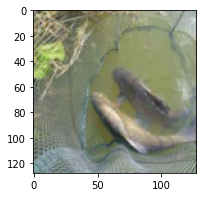

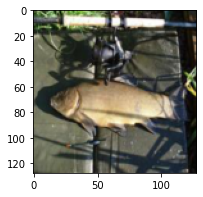

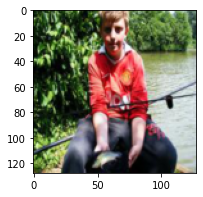

In [4]:
import torchvision.transforms as tfms
train_transform = tfms.Compose([tfms.Resize((128,128)),
                                tfms.ToTensor()])


ImageNette_for_statistics = tv.datasets.ImageFolder('imagenette2-160/train', 
                                    transform = train_transform)

for i in range(3):
    imshow_torch(ImageNette_for_statistics[i][0], figsize=(3,3))

In [5]:
mean, std = [0.46248055, 0.4579692, 0.42981696], [0.27553096, 0.27220666, 0.295335]
print (mean, std)

[0.46248055, 0.4579692, 0.42981696] [0.27553096, 0.27220666, 0.295335]


In [6]:
for data in ImageNette_for_statistics:
    break
print (data[0].shape)

torch.Size([3, 128, 128])


Now lets create the transform and datasets for training, which include [input normalization](https://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn). To avoid overfitting, we may include slight data augmentation into training transform: random cropping and random horizontal flip.


In [7]:
train_transform = tfms.Compose([tfms.Resize((128,128)),
                                tfms.RandomHorizontalFlip(),
                                tfms.ToTensor(),
                                tfms.Normalize(mean, std)])

val_transform = tfms.Compose([tfms.Resize((128,128)),
                              tfms.ToTensor(),
                              tfms.Normalize(mean, std)])
 

ImageNette_train = tv.datasets.ImageFolder('imagenette2-160/train',
                                          transform = train_transform)                       

ImageNette_val = tv.datasets.ImageFolder('imagenette2-160/val', 
                                    transform = val_transform)

Now lets create data loaders. The most important parameters are batch size (number of samples in the mini-batch), number of workers (good idea to match them to number of cores of your CPU or less.

In [8]:
# Taken from here https://stackoverflow.com/a/58748125/1983544
import os
num_workers = os.cpu_count() 
if 'sched_getaffinity' in dir(os):
    num_workers = len(os.sched_getaffinity(0))
print (num_workers)

2


On GPU, the bigger batchsize, the more efficient is training. On the other hand, smaller batch_size may lead to better results on terms of final accuracy. The selection of the proper batch size and other parameters depending on it, is an active research area. We will take the batch of 32. Feel free to adjust it according to your hardware and memory amount.

In [9]:
BS = 32
train_dl = torch.utils.data.DataLoader(ImageNette_train,
                                      batch_size= 32,
                                       shuffle = True, # important thing to do for training. 
                                       num_workers = num_workers)
val_dl = torch.utils.data.DataLoader(ImageNette_val,
                                      batch_size= 32,
                                     shuffle = False,
                                     num_workers = num_workers,
                                     drop_last=False) 
#drop_last means "drop last batch from the dataset.
# if it is smaller than required batch size. Might be good thing to do for training, but not for validation.

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


In [10]:
for data, labels in train_dl:
    break
print (data.shape, labels.shape)

torch.Size([32, 3, 128, 128]) torch.Size([32])


```python
for data, labels in train_dl:
    break
print (data.shape, labels.shape)
```

    torch.Size([32, 3, 128, 128]) torch.Size([32])

Now, lets define a model. It should consist of convolution, non-linearity, pooling, batch-norm layers. And finish with a classifier.

Papers to look for inspiration: 
- [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)
- [VGGNet](https://arxiv.org/pdf/1409.1556)
- [Systematic Evaluation of Convolution Neural Network Advances on the ImageNet](https://arxiv.org/pdf/1606.02228).
- [ResNet](https://arxiv.org/abs/1512.03385)
- [Bag of tricks](https://arxiv.org/abs/1812.01187)
- [Compounding the Performance Improvements of Assembled Techniques
in a Convolutional Neural Network](https://arxiv.org/pdf/2001.06268.pdf)


However, in 99.9% cases, if you are not dealing with super exotic task, it is better to pick of of the known good models. The best repository of vision models is [timm](https://rwightman.github.io/pytorch-image-models/).

Check the [Practical Guide by Chris Hughes](https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055)

In [11]:
import timm

avail_pretrained_models = timm.list_models(pretrained=True)
len(avail_pretrained_models), avail_pretrained_models[:5]

(709,
 ['adv_inception_v3',
  'bat_resnext26ts',
  'beit_base_patch16_224',
  'beit_base_patch16_224_in22k',
  'beit_base_patch16_384'])

The benefit of using pretrained models is two-fold. First, you don't need to define your own architecture.
Second, it is usually much better the fine-tune a model, pretrained on the ImageNet, rather than training your own model from scratch.
The accuracies of the pretrained models are available [here](https://github.com/rwightman/pytorch-image-models/tree/master/results).

We will use something light and simple, e.g. ResNet18.

In [12]:
model = timm.create_model('resnet18', pretrained=True)

We can check some of the parameters, model was trained with, accessing its `default_cfg`:

In [13]:
model.default_cfg

{'architecture': 'resnet18',
 'classifier': 'fc',
 'crop_pct': 0.875,
 'first_conv': 'conv1',
 'input_size': (3, 224, 224),
 'interpolation': 'bilinear',
 'mean': (0.485, 0.456, 0.406),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'std': (0.229, 0.224, 0.225),
 'url': 'https://download.pytorch.org/models/resnet18-5c106cde.pth'}

However, we have 10 classes, not 1000. So, what we will do, is replace pretrained classifier with new, randomly initalized one, and keep the rest of network unchanged.

In [14]:
model = timm.create_model('resnet18', pretrained=True, num_classes=10)
print (model.fc)

Linear(in_features=512, out_features=10, bias=True)


## Training: data + model + optimizer

While we can use pytorch data loaders we have defined above, doing so would limit `fastai` additional functionality. So we will use fastai loaders instead.
It also has an integration with `timm`, so the training will become really simple. 

In [15]:
from fastai.vision.all import *

dls = ImageDataLoaders.from_folder('imagenette2-160/',
                                   valid='val', 
                                   item_tfms=RandomResizedCrop(128, min_scale=0.35),
                                   batch_tfms=Normalize.from_stats(*imagenet_stats))

# if a string is passed into the model argument, it will now use timm (if it is installed)
learn = vision_learner(dls, 'resnet18', metrics=error_rate)


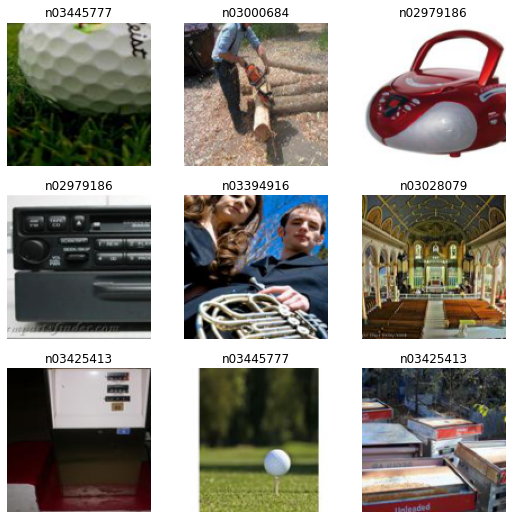

In [16]:
dls.show_batch()

SuggestedLRs(valley=0.00013182566908653826)

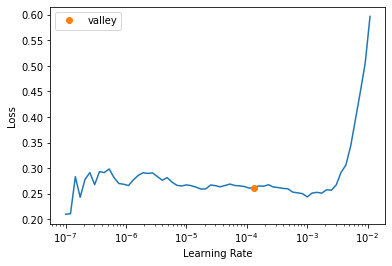

In [18]:
learn.lr_find()

In [19]:
help(learn.fine_tune)

Help on method fine_tune in module fastai.callback.schedule:

fine_tune(epochs, base_lr=0.002, freeze_epochs=1, lr_mult=100, pct_start=0.3, div=5.0, lr_max=None, div_final=100000.0, wd=None, moms=None, cbs=None, reset_opt=False, start_epoch=0) method of fastai.learner.Learner instance
    Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR.



In [20]:
learn.fine_tune(5,base_lr = 2e-4, freeze_epochs=2)

epoch,train_loss,valid_loss,error_rate,time
0,0.258487,0.185694,0.060892,00:30
1,0.223838,0.175536,0.059873,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.236733,0.168433,0.056561,00:31
1,0.222102,0.165639,0.055287,00:30
2,0.221000,0.167945,0.056051,00:30
3,0.216042,0.163816,0.055541,00:30
4,0.212502,0.166371,0.056561,00:30


## Task

Your task is to train a model, which can distinguish between photo of beer and trdelnik. 

In [24]:
from fastai.data.all import *
from fastai.vision.all import *

In [25]:
fnames = get_image_files('data/')

In [35]:
def label_func(fname):
    return str(fname).split('/')[1]

In [36]:
dblock = DataBlock(get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets('data/')
dsets.train[0]

(Path('data/beer/lorenzo-rui-NfjfNQV47OU-unsplash.jpg'), 'beer')

In [39]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets('data/')
dsets.train[0]

(PILImage mode=RGB size=3024x3024, TensorCategory(1))

In [40]:
dsets.vocab

['beer', 'trdelnik']

In [46]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224))

dsets = dblock.datasets('data')
dsets.train[0]

(PILImage mode=RGB size=4000x6000, TensorCategory(0))

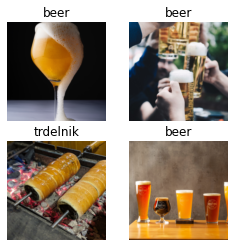

In [62]:
dls = dblock.dataloaders("data", bs=4)
dls.show_batch(max_n=9, figsize=(4,4))

In [65]:
learn = Learner(dls, xresnet34(n_out=2), metrics=accuracy)

In [66]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.863800,0.667481,0.333333,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.316581,0.584947,0.666667,00:08
1,0.397923,0.485821,0.666667,00:07
2,0.393584,0.438613,0.666667,00:07
3,0.362979,0.522844,0.666667,00:08
4,0.331666,0.288754,0.666667,00:07
5,0.288160,0.130117,1.000000,00:07
6,0.267775,0.032108,1.000000,00:07
7,0.384118,0.026806,1.000000,00:07
8,0.341848,0.044611,1.000000,00:07
9,0.324999,0.047776,1.000000,00:07


In [76]:
learn.dl.vocab

['beer', 'trdelnik']

In [79]:
preds, y, losses = learn.get_preds(with_loss=True)

interp = ClassificationInterpretation.from_learner(learn)

(TensorBase([0.1089, 0.0241, 0.0103]), TensorBase([2, 1, 0]))

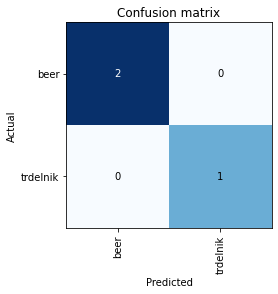

In [81]:
interp.plot_confusion_matrix()

In [ ]:
from google.colab import files
from IPython.display import Image

In [68]:
uploaded = files.upload()

Saving tr1.jpg to tr1.jpg


In [73]:
img=np.array(Image.open('tr1.jpg'))
pred = learn.predict(img)

In [74]:
pred

('beer', TensorBase(0), TensorBase([0.9040, 0.0960]))